<a href="https://colab.research.google.com/github/potipot/cvedia-task/blob/master/assignment_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment - Taxi Time Prediction

## Intro

> [Taxiing](https://en.wikipedia.org/wiki/Taxiing) (rarely spelled taxying) is the movement of an aircraft on the ground, under its own power, in contrast to towing or pushback where the aircraft is moved by a tug. The aircraft usually moves on wheels, but the term also includes aircraft with skis or floats (for water-based travel).

Before take-off an airplane has to move from the gate (or parking stand) to the runway. The time elapsed between gate departure and take-off is called taxi-out. Similarly, the time elapsed between landing and gate arrival is called taxi-in. Notice that taxi-out takes place at origin airport and taxi-in takes place at destination airport.

Generally, for a given flight, taxi-out takes more time than taxi-in.

## Data
### [taxi_data.csv.zip](https://drive.google.com/file/d/1wNsxf9X3v5nTupIKZPn67aVCOBoJqbbb/view?usp=sharing) (213MB)

   Two years (2019 and 2020) of U.S. flight data reported to Department of Transportation. Columns description you can find [here](https://docs.google.com/document/d/1KmvWbMW-wFyNd6E_5MQ1ipkLpMZBmrMNl15jzgycZs0/edit?usp=sharing).
    
## Task
Your task is to create model(s) to predict future taxi-out and taxi-in times. 

You are free to use any statistical/ML technique(s). Please update the `requirements.txt` with appropriate package and version whenever you decide to use new package.

You don't have to process the data and train the model inside docker container. It will be probably better to do it outside of docker.

During the review of your assignment we will assess your whole ML workflow.

Below you can see the code to load the data into dataframe. Notice that you have to download the data first and put it in the same directory with notebook before executing the cells below.

In [1]:
!gdown --id 1wNsxf9X3v5nTupIKZPn67aVCOBoJqbbb


Downloading...
From: https://drive.google.com/uc?id=1wNsxf9X3v5nTupIKZPn67aVCOBoJqbbb
To: /content/taxi_data.csv.zip
224MB [00:01, 147MB/s]


In [8]:
!pip install fastai==2.3.0
!pip install wandb
!pip install fastparquet

  Using cached https://files.pythonhosted.org/packages/5b/53/edf39e15b7ec5e805a0b6f72adbe48497ebcfa009a245eca7044ae9ee1c6/fastai-2.3.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/94/df/969e69a94cff1c8911acb0688117f95e1915becc1e01c73e7960a2c76ec8/torchvision-0.8.2-cp37-cp37m-manylinux1_x86_64.whl
     |████████████████████████████████| 776.8MB 23kB/s 
  Using cached https://files.pythonhosted.org/packages/0c/98/60404e2817cff113a6ae4023bc1772e23179408fdf7857fa410551758dfe/fastcore-1.3.19-py3-none-any.whl
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.6

# Load data into dataframe

In [9]:
import numpy as np
import pandas as pd

In [10]:
from fastai.tabular.all import *
from fastai.callback.wandb import *
import wandb

taxi_df = pd.read_csv("taxi_data.csv.zip", compression="zip")

In [20]:
taxi_df = pd.read_csv("taxi_data.csv.zip", compression="zip")

# Clean up date

In [21]:
make_date(taxi_df, 'FlightDate')

## convert datatypes to consume less memory

In [22]:
taxi_df = df_shrink(taxi_df)

In [23]:
taxi_df.head()

,Year,FlightDate,Reporting_Airline,Origin,OriginCityName,OriginState,Dest,DestCityName,DestState,DepTime,TaxiOut,WheelsOff,WheelsOn,TaxiIn,ArrTime,Cancelled,Diverted,AirTime,DivReachedDest
0,2020,2020-12-01,9E,CVG,"Cincinnati, OH",KY,BOS,"Boston, MA",MA,851.0,60.0,951.0,1127.0,6.0,1133.0,0.0,0.0,96.0,NaN
1,2020,2020-12-03,9E,CVG,"Cincinnati, OH",KY,BOS,"Boston, MA",MA,729.0,44.0,813.0,948.0,5.0,953.0,0.0,0.0,95.0,NaN
2,2020,2020-12-04,9E,CVG,"Cincinnati, OH",KY,BOS,"Boston, MA",MA,726.0,10.0,736.0,907.0,7.0,914.0,0.0,0.0,91.0,NaN
3,2020,2020-12-06,9E,CVG,"Cincinnati, OH",KY,BOS,"Boston, MA",MA,723.0,22.0,745.0,926.0,6.0,932.0,0.0,0.0,101.0,NaN
4,2020,2020-12-07,9E,CVG,"Cincinnati, OH",KY,BOS,"Boston, MA",MA,720.0,12.0,732.0,912.0,7.0,919.0,0.0,0.0,100.0,NaN


## filter out indexes and drop some columns

In [24]:
is_cancelled = taxi_df.Cancelled == 1.0
taxi_df = taxi_df[~is_cancelled]

# dropping diverted for now
is_diverted = (taxi_df.Diverted == 1.0)
taxi_df = taxi_df[~is_diverted]

In [25]:
taxi_df.drop(columns=['Year', 'Cancelled', "DivReachedDest", "Diverted"], inplace=True)

# Handle target columns

Inserting 0 for missing taxi values

In [26]:
taxi_df["TaxiIn"].fillna(0, inplace=True)
taxi_df["TaxiOut"].fillna(0, inplace=True)

Manually fixing some NaNs

In [27]:
taxi_df.describe()

,DepTime,TaxiOut,WheelsOff,WheelsOn,TaxiIn,ArrTime,AirTime
count,1.166781e+07,1.166781e+07,1.166781e+07,1.166781e+07,1.166781e+07,1.166781e+07,1.166781e+07
mean,1.351334e+03,1.688213e+01,1.371471e+03,1.470364e+03,7.430322e+00,1.473937e+03,1.106482e+02
std,4.902738e+02,9.348299e+00,4.894339e+02,5.132986e+02,5.701215e+00,5.169222e+02,6.852058e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00
25%,9.180000e+02,1.100000e+01,9.330000e+02,1.053000e+03,4.000000e+00,1.057000e+03,6.000000e+01
50%,1.321000e+03,1.400000e+01,1.334000e+03,1.502000e+03,6.000000e+00,1.506000e+03,9.300000e+01
75%,1.733000e+03,1.900000e+01,1.747000e+03,1.904000e+03,9.000000e+00,1.909000e+03,1.400000e+02
max,2.400000e+03,2.270000e+02,2.400000e+03,2.400000e+03,3.160000e+02,2.400000e+03,1.557000e+03


In [28]:
# converting to HasReachedDest
# taxi_df["DivReachedDest"].fillna(1.0, inplace=True)

# if not flown there is no airtime
taxi_df["AirTime"].fillna(0.0, inplace=True)

# Handle FlightDate

In [29]:
taxi_df = add_datepart(taxi_df, 'FlightDate')

In [31]:
taxi_df.head()

,Reporting_Airline,Origin,OriginCityName,OriginState,Dest,DestCityName,DestState,DepTime,TaxiOut,WheelsOff,WheelsOn,TaxiIn,ArrTime,AirTime,FlightYear,FlightMonth,FlightWeek,FlightDay,FlightDayofweek,FlightDayofyear,FlightIs_month_end,FlightIs_month_start,FlightIs_quarter_end,FlightIs_quarter_start,FlightIs_year_end,FlightIs_year_start,FlightElapsed
0,9E,CVG,"Cincinnati, OH",KY,BOS,"Boston, MA",MA,851.0,60.0,951.0,1127.0,6.0,1133.0,96.0,2020,12,49,1,1,336,False,True,False,False,False,False,1.606781e+09
1,9E,CVG,"Cincinnati, OH",KY,BOS,"Boston, MA",MA,729.0,44.0,813.0,948.0,5.0,953.0,95.0,2020,12,49,3,3,338,False,False,False,False,False,False,1.606954e+09
2,9E,CVG,"Cincinnati, OH",KY,BOS,"Boston, MA",MA,726.0,10.0,736.0,907.0,7.0,914.0,91.0,2020,12,49,4,4,339,False,False,False,False,False,False,1.607040e+09
3,9E,CVG,"Cincinnati, OH",KY,BOS,"Boston, MA",MA,723.0,22.0,745.0,926.0,6.0,932.0,101.0,2020,12,49,6,6,341,False,False,False,False,False,False,1.607213e+09
4,9E,CVG,"Cincinnati, OH",KY,BOS,"Boston, MA",MA,720.0,12.0,732.0,912.0,7.0,919.0,100.0,2020,12,50,7,0,342,False,False,False,False,False,False,1.607299e+09


In [32]:
taxi_df.columns

Index(['Reporting_Airline', 'Origin', 'OriginCityName', 'OriginState', 'Dest',
       'DestCityName', 'DestState', 'DepTime', 'TaxiOut', 'WheelsOff',
       'WheelsOn', 'TaxiIn', 'ArrTime', 'AirTime', 'FlightYear', 'FlightMonth',
       'FlightWeek', 'FlightDay', 'FlightDayofweek', 'FlightDayofyear',
       'FlightIs_month_end', 'FlightIs_month_start', 'FlightIs_quarter_end',
       'FlightIs_quarter_start', 'FlightIs_year_end', 'FlightIs_year_start',
       'FlightElapsed'],
      dtype='object')

# Create dataset

In [33]:
categorical_columns = [
    'Reporting_Airline', 'Origin', 'OriginCityName', 'OriginState', 'Dest', 'DestCityName', 'DestState',
    'DepTime', 'WheelsOff', 'WheelsOn', 'ArrTime', 'FlightYear', 'FlightMonth',
    'FlightWeek', 'FlightDay', 'FlightDayofweek', 'FlightDayofyear',
    'FlightIs_month_end', 'FlightIs_month_start', 'FlightIs_quarter_end',
    'FlightIs_quarter_start', 'FlightIs_year_end', 'FlightIs_year_start',
    ]

continous_columns = ['AirTime', "FlightElapsed"]

y_columns = ['TaxiIn', 'TaxiOut']

In [34]:
subset = taxi_df#.sample(n=10000)

In [35]:
splits = RandomSplitter()(range_of(subset))

In [36]:
to = TabularPandas(
    subset, 
    cat_names=categorical_columns,
    cont_names=continous_columns,
    y_names=y_columns,
    procs=[Categorify, FillMissing, Normalize],
    splits=splits
)

In [37]:
dls = to.dataloaders(bs=128)

In [38]:
dls.show_batch()

,Reporting_Airline,Origin,OriginCityName,OriginState,Dest,DestCityName,DestState,DepTime,WheelsOff,WheelsOn,ArrTime,FlightYear,FlightMonth,FlightWeek,FlightDay,FlightDayofweek,FlightDayofyear,FlightIs_month_end,FlightIs_month_start,FlightIs_quarter_end,FlightIs_quarter_start,FlightIs_year_end,FlightIs_year_start,AirTime,FlightElapsed,TaxiIn,TaxiOut
0,WN,DEN,"Denver, CO",CO,SLC,"Salt Lake City, UT",UT,1611,1622,1725,1731,2019,11,44,3,6,307,False,False,False,False,False,False,62.999999,1.572739e+09,6.0,11.0
1,YX,EWR,"Newark, NJ",NJ,CVG,"Cincinnati, OH",KY,1724,1742,1921,1926,2019,11,47,22,4,326,False,False,False,False,False,False,99.000000,1.574381e+09,5.0,18.0
2,AS,PDX,"Portland, OR",OR,HNL,"Honolulu, HI",HI,915,927,1142,1243,2019,9,38,16,0,259,False,False,False,False,False,False,315.000006,1.568592e+09,61.0,12.0
3,WN,HOU,"Houston, TX",TX,LAS,"Las Vegas, NV",NV,2146,2153,2250,2253,2020,2,8,19,2,50,False,False,False,False,False,False,176.999999,1.582070e+09,3.0,7.0
4,F9,MCO,"Orlando, FL",FL,ATL,"Atlanta, GA",GA,1220,1230,1341,1352,2020,12,53,31,3,366,True,False,True,False,True,False,71.000000,1.609373e+09,11.0,10.0
5,WN,DEN,"Denver, CO",CO,EWR,"Newark, NJ",NJ,1132,1200,1708,1717,2019,10,40,1,1,274,False,True,False,True,False,False,188.000003,1.569888e+09,9.0,28.0
6,F9,ATL,"Atlanta, GA",GA,LAS,"Las Vegas, NV",NV,2359,12,100,110,2019,10,43,24,3,297,False,False,False,False,False,False,228.000002,1.571875e+09,10.0,13.0
7,YX,SDF,"Louisville, KY",KY,DTW,"Detroit, MI",MI,1834,1847,1940,1946,2019,10,41,9,2,282,False,False,False,False,False,False,52.999999,1.570579e+09,6.0,13.0
8,UA,RDU,"Raleigh/Durham, NC",NC,ORD,"Chicago, IL",IL,1717,1806,1850,1907,2019,4,17,24,2,114,False,False,False,False,False,False,104.000000,1.556064e+09,17.0,49.0
9,OO,DTW,"Detroit, MI",MI,ORD,"Chicago, IL",IL,557,607,555,610,2019,5,20,19,6,139,False,False,False,False,False,False,48.000002,1.558224e+09,15.0,10.0


# Create metrics and model

In [39]:
def slice_input(metric_func, input_idx):
    def inner(inp, targ):
        return metric_func(inp[:,input_idx], targ[:,input_idx])
    return inner


class MetricWrapper(AvgMetric):
    def __init__(self, func, name, input_idx):
        func = slice_input(func, input_idx)
        super().__init__(func)
        self._name = name
        
    @property
    def name(self):  return self._name


metrics = [
    MetricWrapper(mse, 'taxi_in_mse', 0),
    MetricWrapper(mse, 'taxi_out_mse', 1),
    MetricWrapper(R2Score(), 'taxi_in_r2', 0),
    MetricWrapper(R2Score(), 'taxi_out_r2', 1),
]

In [40]:
learn = tabular_learner(dls, metrics=[taxi_in_mse, taxi_out_mse])

# Find optimal learning rate

SuggestedLRs(lr_min=0.009638290107250213, lr_steep=0.0016143585089594126)

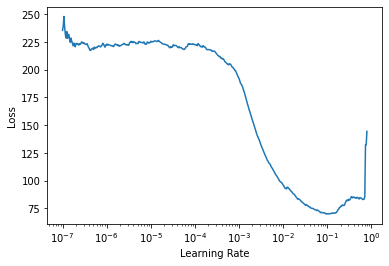

In [41]:
learn.lr_find(num_it=500)

# Configure wandb logging

In [42]:
experiment_name = "keep-FlightDate-fixed-metrics"

In [43]:
wandb.init(project='taxi-time', name=experiment_name);

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Train

In [ ]:
learn.fit_flat_cos(10, 5e-3, pct_start=0.5, cbs=[SaveModelCallback(fname=experiment_name), WandbCallback()])

epoch,train_loss,valid_loss,taxi_in_mse,taxi_out_mse,time
0,7.041901,8.616673,7.565086,8.419264,42:03


Better model found at epoch 0 with valid_loss value: 8.61667251586914.


In [ ]:
learn.show_results()

,Reporting_Airline,Origin,OriginCityName,OriginState,Dest,DestCityName,DestState,DepTime,WheelsOff,WheelsOn,AirTime,TaxiIn,TaxiOut,TaxiIn_pred,TaxiOut_pred
0,2.0,330.0,290.0,5.0,99.0,83.0,44.0,1156.0,1168.0,111.0,0.809138,5.0,10.0,11.633522,10.780287
1,14.0,196.0,199.0,5.0,158.0,150.0,10.0,816.0,831.0,1027.0,3.167663,5.0,14.0,7.272551,12.047436
2,6.0,170.0,151.0,44.0,204.0,182.0,17.0,1026.0,1041.0,1121.0,-1.052108,7.0,15.0,6.265943,19.201382
3,17.0,223.0,218.0,44.0,170.0,151.0,44.0,785.0,813.0,916.0,-0.711117,17.0,27.0,4.576787,8.498371
4,1.0,48.0,41.0,18.0,185.0,235.0,33.0,604.0,643.0,726.0,-0.995276,7.0,38.0,11.435070,17.863216
5,13.0,292.0,33.0,36.0,270.0,262.0,4.0,487.0,504.0,721.0,0.056114,5.0,16.0,8.157559,14.195477
6,5.0,74.0,69.0,34.0,23.0,20.0,9.0,753.0,762.0,885.0,-0.426957,6.0,8.0,4.948223,18.699223
7,4.0,218.0,250.0,8.0,327.0,300.0,38.0,561.0,573.0,821.0,0.496562,6.0,11.0,4.126197,11.923960
8,5.0,23.0,20.0,9.0,175.0,155.0,14.0,488.0,499.0,607.0,-0.640077,4.0,10.0,5.663379,11.147790
